In [19]:
import networkx as nx
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [21]:
plt.rcParams["figure.figsize"] = (20,3)

In [22]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import load_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [23]:
DATASET = DatasetPath('DBLP-HCN')
schema = DatasetSchema.load_schema(DATASET.name)
G = load_igraph(schema)

In [24]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [25]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

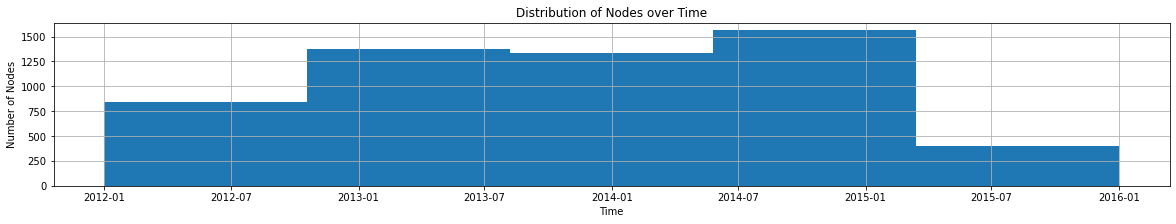

In [26]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [27]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [28]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 10687
Number of Edges: 16533
Density: 0.00028954140812534833


In [29]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [30]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 3.0940394872274726
Median Degree: 3.0


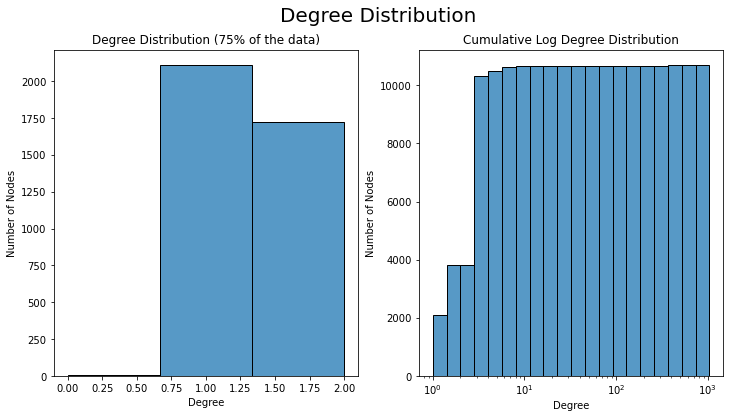

In [31]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [32]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,1041,aaai
1,898,cvpr
2,689,nips
3,474,icdm
4,462,icml
5,461,ijcai
6,299,icde
7,240,pkdd
8,210,pakdd
9,198,ecir


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [33]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [34]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.0
Diameter: 12


In [35]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

Eigenvector Centrality Error: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')


,degree_centrality,betweenness_centrality,page_rank,transitivity
count,10683.000000,10683.000000,10683.000000,8576.0
mean,0.000290,0.000379,0.000094,0.0
std,0.001649,0.008658,0.000447,0.0
min,0.000094,0.000000,0.000039,0.0
25%,0.000187,0.000000,0.000065,0.0
50%,0.000281,0.000043,0.000084,0.0
75%,0.000281,0.000140,0.000093,0.0
max,0.097454,0.853482,0.025851,0.0


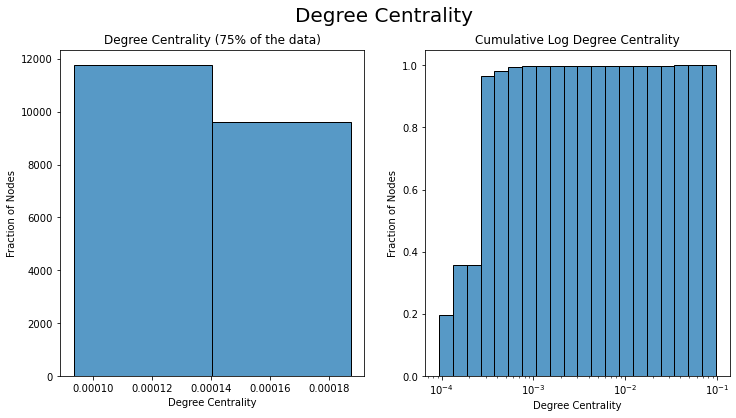

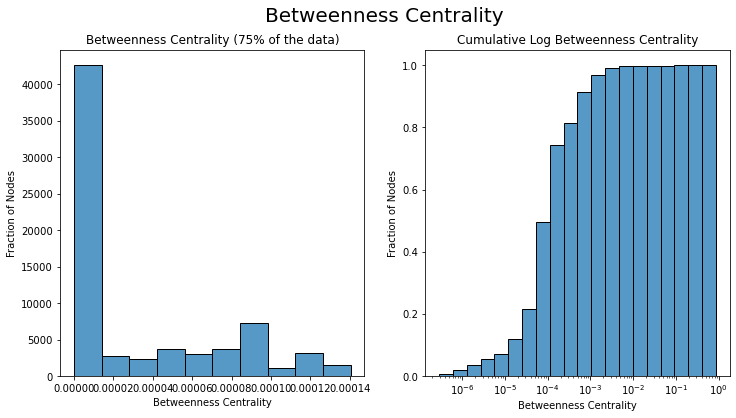

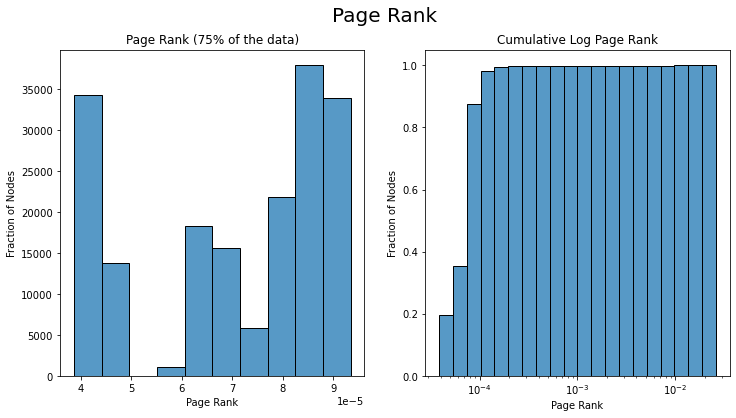

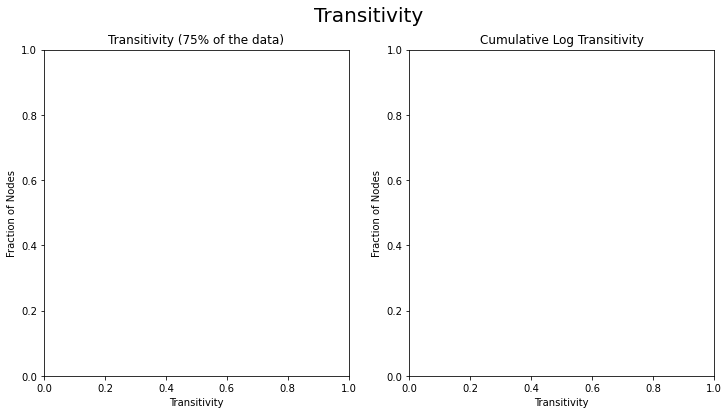

In [36]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [37]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.097454,aaai,0.853482,aaai,0.025851,aaai,0.0,Ashish Sabharwal
1,0.084067,cvpr,0.137574,cvpr,0.023406,cvpr,0.0,New Rules for Domain Independent Lifted MAP In...
2,0.064501,nips,0.119497,Linli Xu,0.017231,nips,0.0,Lena Gorelick
3,0.044374,icdm,0.092130,nips,0.012292,icdm,0.0,Merging in the Horn Fragment.
4,0.043250,icml,0.091951,icdm,0.011525,ijcai,0.0,Global Convergence of Stochastic Gradient Desc...
5,0.043157,ijcai,0.053762,Word Embedding Revisited: A New Representation...,0.011262,icml,0.0,Christopher De Sa
6,0.027991,icde,0.053668,ijcai,0.008234,icde,0.0,Effective Similarity Search on Indoor Moving-O...
7,0.022468,pkdd,0.053486,icml,0.006225,pkdd,0.0,Peiquan Jin
8,0.019659,pakdd,0.052403,icde,0.005861,ecir,0.0,Online Discovery of Group Level Events in Time...
9,0.018536,ecir,0.035478,ecir,0.005586,pakdd,0.0,Abdullah Mueen


## Connected Components Statistics

In [38]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 5
Size of the largest component: 10683


Text(0.5, 1.0, 'Connected Components')

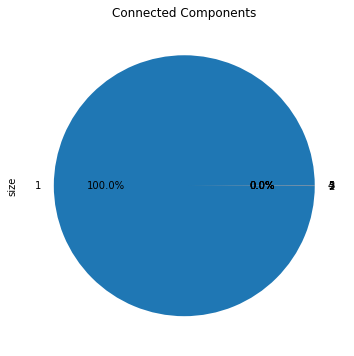

In [39]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components())], index=range(1,len(G.components())+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [40]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 3


,type,count,degree_avg,degree_median
Author,Author,5162,2.135219,2.0
Venue,Venue,14,393.642857,269.5
Paper,Paper,5511,3.000000,3.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

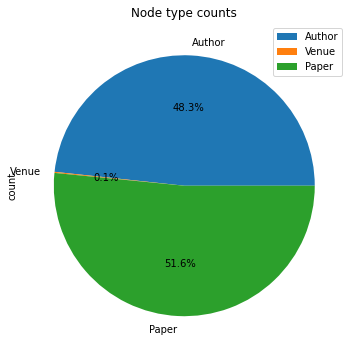

In [41]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

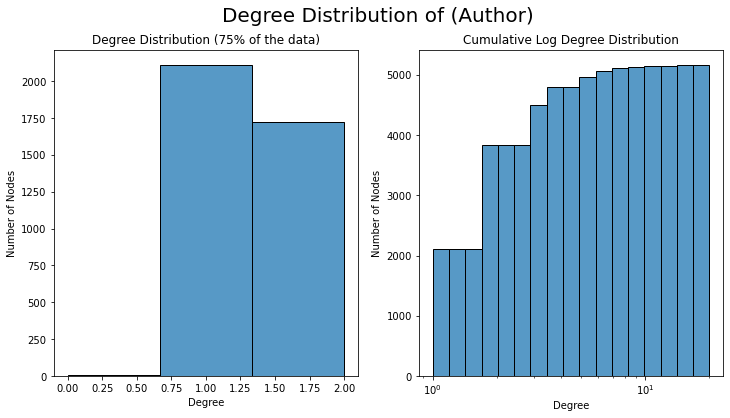

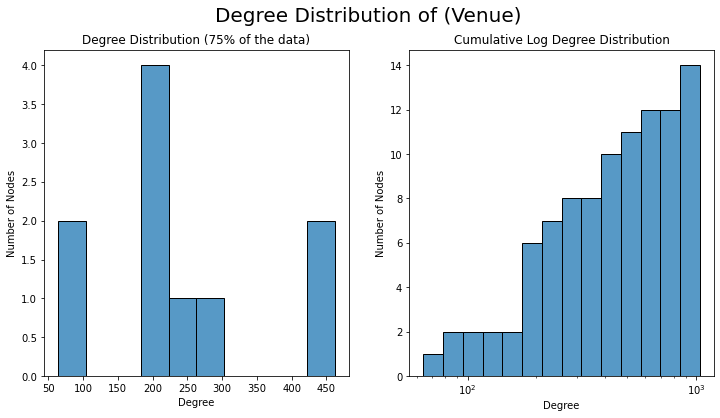

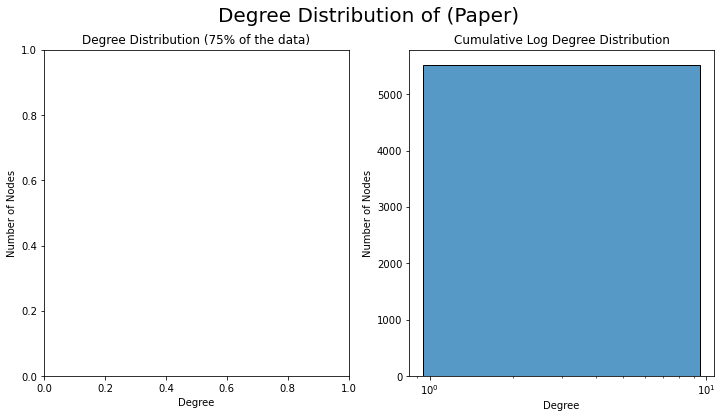

In [42]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [43]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Author)


,value,label
0,20,Feiping Nie
1,19,Jos&eacute
2,16,Jun Zhu
3,15,Jiliang Tang
4,13,Deguang Kong
5,13,Chris H. Q. Ding
6,13,Andr&eacute
7,13,Huan Xu
8,13,Peng Zhang
9,12,Kyoung Mu Lee


Top 10 Degree Nodes of Type (Venue)


,value,label
0,1041,aaai
1,898,cvpr
2,689,nips
3,474,icdm
4,462,icml
5,461,ijcai
6,299,icde
7,240,pkdd
8,210,pakdd
9,198,ecir


Top 10 Degree Nodes of Type (Paper)


,value,label
0,3,Metadata-as-a-Service.
1,3,Stick-Breaking Policy Learning in Dec-POMDPs.
2,3,Latent Factor BlockModel for Modelling Relatio...
3,3,Identigram/watermark removal using cross-chann...
4,3,Street-to-shop: Cross-scenario clothing retrie...
5,3,Discriminative spatial saliency for image clas...
6,3,Latent Semantic Representation Learning for Sc...
7,3,Language-Based Games.
8,3,Bags of Spacetime Energies for Dynamic Scene R...
9,3,A Scalable Data Analytics Algorithm for Mining...


### Edge Type Statistics

In [44]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 2


,type,count
AUTHORED,AUTHORED,11022
PUBLISHED_IN,PUBLISHED_IN,5511


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

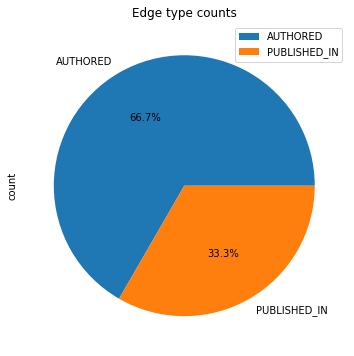

In [45]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [46]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [47]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Author


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001872,Feiping Nie,0.119497,Linli Xu,0.000453,Feiping Nie,0.0,Greg Ver Steeg
1,0.001779,Jos&eacute,0.026928,Yitan Li,0.000444,Jos&eacute,0.0,Edith Elkind
2,0.001498,Jun Zhu,0.015961,Xin Wang,0.000371,Jun Zhu,0.0,Zhiquan Qi
3,0.001404,Jiliang Tang,0.010690,Jun Zhu,0.000341,Jiliang Tang,0.0,Han Su
4,0.001217,Chris H. Q. Ding,0.008813,Feiping Nie,0.000330,Peng Zhang,0.0,Vasiliy Karasev
5,0.001217,Deguang Kong,0.008514,Yu Zhang,0.000328,Andr&eacute,0.0,Aijun An
6,0.001217,Andr&eacute,0.008482,J&ouml,0.000309,Deguang Kong,0.0,Hongdong Li
7,0.001217,Peng Zhang,0.008331,Chao Zhang,0.000307,Lei Chen 0002,0.0,Jianpeng Xu
8,0.001217,Huan Xu,0.008238,Wei Chen,0.000304,Huan Xu,0.0,Minh Luan Nguyen
9,0.001123,Kyoung Mu Lee,0.007713,Xin Li,0.000300,Chris H. Q. Ding,0.0,Sejong Yoon


Top 10 Nodes by Statistic for Venue


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.097454,aaai,0.853482,aaai,0.025851,aaai,0.0,dasfaa
1,0.084067,cvpr,0.137574,cvpr,0.023406,cvpr,0.0,icdm
2,0.064501,nips,0.092130,nips,0.017231,nips,0.0,pakdd
3,0.044374,icdm,0.091951,icdm,0.012292,icdm,0.0,sdm
4,0.043250,icml,0.053668,ijcai,0.011525,ijcai,0.0,vldb
5,0.043157,ijcai,0.053486,icml,0.011262,icml,0.0,ijcai
6,0.027991,icde,0.052403,icde,0.008234,icde,0.0,www
7,0.022468,pkdd,0.035478,ecir,0.006225,pkdd,0.0,aaai
8,0.019659,pakdd,0.029932,pkdd,0.005861,ecir,0.0,icde
9,0.018536,ecir,0.029158,dasfaa,0.005586,pakdd,0.0,ecir


Top 10 Nodes by Statistic for Paper


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000281,SWORD: workload-aware data placement and repli...,0.053762,Word Embedding Revisited: A New Representation...,0.00012,Join the Living Lab: Evaluating News Recommend...,0.0,SWORD: workload-aware data placement and repli...
1,0.000281,Markov Network Estimation From Multi-attribute...,0.030775,Robust Dynamic Trajectory Regression on Road N...,0.00012,Using Document-Quality Measures to Predict Web...,0.0,Markov Network Estimation From Multi-attribute...
2,0.000281,Finding Galaxies in the Shadows of Quasars wit...,0.030775,Feature Selection with Integrated Relevance an...,0.00012,Learning to Rank Aggregated Answers for Crossw...,0.0,Finding Galaxies in the Shadows of Quasars wit...
3,0.000281,An Aligned Subtree Kernel for Weighted Graphs.,0.030739,Learning Low-Rank Label Correlations for Multi...,0.00012,Different Rankers on Different Subcollections.,0.0,An Aligned Subtree Kernel for Weighted Graphs.
4,0.000281,The Coherent Loss Function for Classification.,0.007797,Proximal Operators for Multi-Agent Path Planning.,0.00012,Two-Stage Learning to Rank for Information Ret...,0.0,The Coherent Loss Function for Classification.
5,0.000281,Joint Transfer and Batch-mode Active Learning.,0.005941,ExpFinder: Finding experts by graph pattern ma...,0.00012,Explaining Query Modifications - An Alternativ...,0.0,Joint Transfer and Batch-mode Active Learning.
6,0.000281,Covariate Shift in Hilbert Space: A Solution v...,0.005941,Answering graph pattern queries using views.,0.00012,Distributional Correspondence Indexing for Cro...,0.0,Covariate Shift in Hilbert Space: A Solution v...
7,0.000281,Algorithms for the Hard Pre-Image Problem of S...,0.005920,A real-time abnormality detection system for i...,0.00012,Learning Word Embeddings from Wikipedia for Co...,0.0,Algorithms for the Hard Pre-Image Problem of S...
8,0.000281,Learning Program Embeddings to Propagate Feedb...,0.005861,MARS: A multi-aspect Recommender system for Po...,0.00012,On Aggregating Labels from Multiple Crowd Work...,0.0,Learning Program Embeddings to Propagate Feedb...
9,0.000281,Reducing Dueling Bandits to Cardinal Bandits.,0.005833,Coupled clustering ensemble: Incorporating cou...,0.00012,Intent-Based Browse Activity Segmentation.,0.0,Reducing Dueling Bandits to Cardinal Bandits.


# Clustering

## No Clustering Modularity

In [48]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [49]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.7754806211393303
Number of communities: 69


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

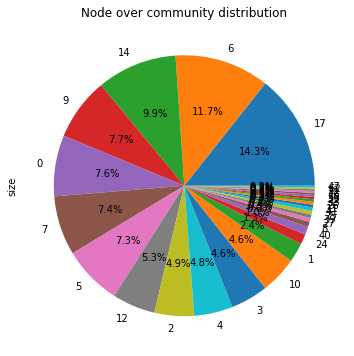

In [50]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.027991,icde,0.052403,icde,0.008234,icde,0.0,Abdul Quamar
1,0.008800,vldb,0.014569,vldb,0.002562,vldb,0.0,SHAHED: A MapReduce-based system for querying ...
2,0.000843,Kai Zheng,0.005941,Answering graph pattern queries using views.,0.000221,Kai Zheng,0.0,Acronym Disambiguation Using Word Embedding.
3,0.000655,Reynold Cheng,0.005941,ExpFinder: Finding experts by graph pattern ma...,0.000194,Reynold Cheng,0.0,Materialized views for eventually consistent r...
4,0.000655,Mohamed F. Mokbel,0.005272,Relaxed Majorization-Minimization for Non-Smoo...,0.000181,Mohamed F. Mokbel,0.0,Challenges for Dataset Search.
5,0.000562,Zhifeng Bao,0.004484,Social Context-Aware Trust Network Discovery i...,0.000162,Zhifeng Bao,0.0,Compiled Plans for In-Memory Path-Counting Que...
6,0.000562,Raymond Chi-Wing Wong,0.004297,Guanfeng Liu,0.000162,Wenfei Fan,0.0,LSII: An indexing structure for exact real-tim...
7,0.000562,Wenfei Fan,0.003564,Chen Xu,0.000155,Martin Faust,0.0,Bi-temporal Timeline Index: A data structure f...
8,0.000562,Jeffrey Xu Yu,0.002301,Time-Varying Clusters in Large-Scale Flow Cyto...,0.000155,Jeffrey Xu Yu,0.0,Continuous data cleaning.
9,0.000562,Martin Faust,0.002120,Chao Li,0.000150,Raymond Chi-Wing Wong,0.0,A general graph-based model for recommendation...


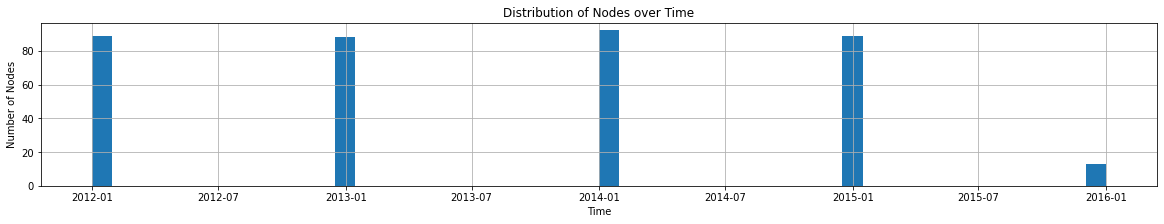

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.005991,www,0.008616,www,0.001762,www,0.0,Shi Feng
1,0.001123,Lei Chen 0002,0.007713,Xin Li,0.000307,Lei Chen 0002,0.0,On personalized and sequenced route planning.
2,0.000655,Mingsheng Long,0.005861,MARS: A multi-aspect Recommender system for Po...,0.000176,Xin Li,0.0,Unsupervised Sentiment Analysis for Social Med...
3,0.000655,Xin Li,0.004492,Guiguang Ding,0.000176,Mingsheng Long,0.0,Collective Matrix Factorization Hashing for Mu...
4,0.000655,Guiguang Ding,0.003895,Mingsheng Long,0.000171,Guiguang Ding,0.0,Semantics-preserving hashing for cross-view re...
5,0.000562,Jianzhong Qi,0.002822,Transductive Zero-Shot Recognition via Shared ...,0.000166,Ke Wang,0.0,Content + Attributes: A Latent Factor Model fo...
6,0.000562,Ke Wang,0.002822,Active Learning with Cross-Class Knowledge Tra...,0.000157,Guandong Xu,0.0,Sparse Adaptive Multi-hyperplane Machine.
7,0.000562,Guandong Xu,0.002712,Fraudulent Support Telephone Number Identifica...,0.000156,Jianzhong Qi,0.0,Coupling Multiple Views of Relations for Recom...
8,0.000468,Junjie Wu,0.002641,Transfer Learning with Graph Co-Regularization.,0.000142,Junjie Wu,0.0,Exploiting small world property for network cl...
9,0.000468,Rui Zhang 0003,0.002636,Are Features Equally Representative? A Feature...,0.000131,Rui Zhang 0003,0.0,Evaluating continuous top-k queries over docum...


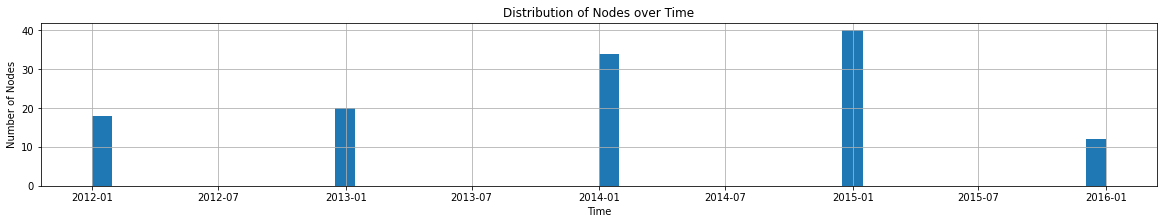

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.017974,sdm,0.018024,sdm,0.004806,sdm,0.0,James Bailey
1,0.001404,Jiliang Tang,0.004238,Jiliang Tang,0.000341,Jiliang Tang,0.0,"Retweeting: An Act of Viral Users, Susceptible..."
2,0.000843,Charu C. Aggarwal,0.002611,Senzhang Wang,0.000216,Charu C. Aggarwal,0.0,Embedded Unsupervised Feature Selection.
3,0.000749,Xia Hu,0.002223,Sembler: Ensembling Crowd Sequential Labeling ...,0.000188,Ruilin Liu,0.0,Mixed-Transfer: Transfer Learning over Mixed G...
4,0.000655,Ruilin Liu,0.001710,OMNI-Prop: Seamless Node Classification on Arb...,0.000183,Xia Hu,0.0,Fine-Grained Photovoltaic Output Prediction Us...
5,0.000655,Hanghang Tong,0.001678,Wei Fan,0.000174,Hanghang Tong,0.0,Adaptive Heterogeneous Ensemble Learning Using...
6,0.000562,Leman Akoglu,0.001670,Identifying At-Risk Students in Massive Open O...,0.000162,Leman Akoglu,0.0,Social Role Identification via Dual Uncertaint...
7,0.000562,Wei Fan,0.001567,Exploiting Transitive Similarity and Temporal ...,0.000157,Yu Cheng,0.0,Data Mining a Trillion Time Series Subsequence...
8,0.000562,Yu Cheng,0.001446,Negative Influence Minimizing by Blocking Node...,0.000156,Wei Fan,0.0,Social Spammer Detection in Microblogging.
9,0.000562,Karthik Subbian,0.001446,Burst Time Prediction in Cascades.,0.000148,Karthik Subbian,0.0,GBPR: Group Preference Based Bayesian Personal...


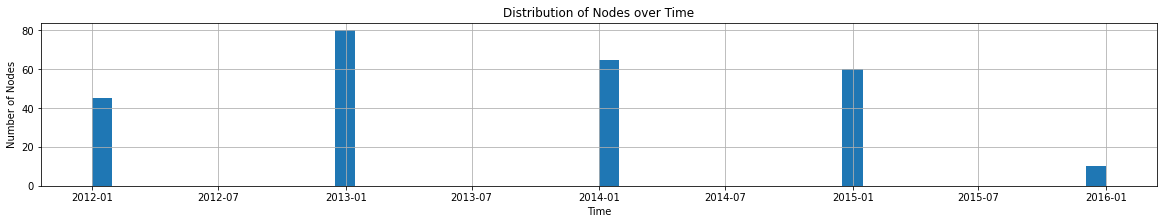

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.017693,dasfaa,0.029158,dasfaa,0.005124,dasfaa,0.0,Hailong Sun
1,0.000843,Wei Chen,0.008238,Wei Chen,0.000236,Wei Chen,0.0,Tracing Influential Nodes in a Social Network ...
2,0.000655,Feida Zhu,0.003249,Social Emotion Classification via Reader Persp...,0.000193,Feida Zhu,0.0,Schema Matching Based on Source Codes.
3,0.000562,Nguyen Quoc Viet Hung,0.003205,Towards Optimal Binary Code Learning via Ordin...,0.000164,Zi Huang,0.0,Exploiting Human Mobility Patterns for Gas Sta...
4,0.000562,Zi Huang,0.003041,Improving Semi-Supervised Target Alignment via...,0.000156,Nguyen Quoc Viet Hung,0.0,CITPM: A Cluster-Based Iterative Topical Phras...
5,0.000468,Furu Wei,0.002697,Kai Zhang,0.000143,Jun Li,0.0,Deep Modeling of Group Preferences for Group-B...
6,0.000468,Jun Li,0.002366,Jun Li,0.000139,Hao Huang,0.0,Data Management Challenges and Opportunities i...
7,0.000468,Wei Cao,0.002306,Cross-Lingual Knowledge Validation Based Taxon...,0.000138,Marwan Hassani,0.0,Distributed Data Managing in Health Care Socia...
8,0.000468,Hao Huang,0.002217,Bing Li,0.000136,Kai Zhang,0.0,Emerging event detection in social networks wi...
9,0.000468,Marwan Hassani,0.002177,On the Depth of Deep Neural Networks: A Theore...,0.000134,Wei Cao,0.0,A Collaborative Filtering Model for Personaliz...


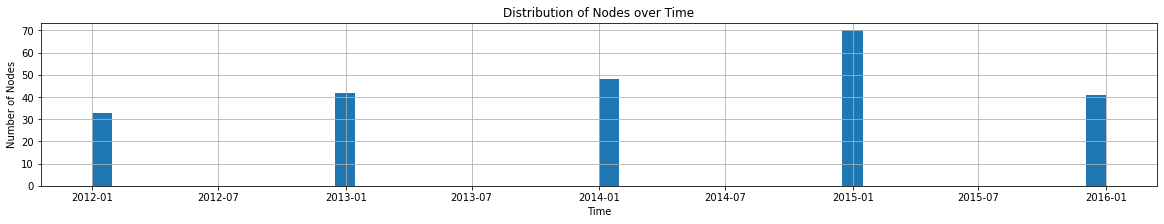

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.022468,pkdd,0.029932,pkdd,0.006225,pkdd,0.0,Michael Kamp
1,0.000936,Huzefa Rangwala,0.003412,Yuhong Guo,0.000245,Huzefa Rangwala,0.0,Generalizing Patterns for Cross-Domain Analogy.
2,0.000936,Yuhong Guo,0.003299,Nonparametric Scoring Rules.,0.000232,Yuhong Guo,0.0,A Triclustering Approach for Time Evolving Gra...
3,0.000843,S&eacute,0.003112,S&eacute,0.000227,S&eacute,0.0,Communication-Efficient Distributed Online Pre...
4,0.000655,Kristian Kersting,0.002543,Convex Co-embedding.,0.000183,Kristian Kersting,0.0,Country-Scale Exploratory Analysis of Call Det...
5,0.000562,Eyke H&uuml,0.002276,Semi-Supervised Kernel Matching for Domain Ada...,0.000164,Eyke H&uuml,0.0,HierCost: Improving Large Scale Hierarchical C...
6,0.000468,Michele Berlingerio,0.001788,Kristian Kersting,0.000144,Michele Berlingerio,0.0,Ising Bandits with Side Information.
7,0.000468,Yaoliang Yu,0.001556,Fast Gradient Descent for Drifting Least Squar...,0.000132,Yaoliang Yu,0.0,Non-Negative Multiple Matrix Factorization.
8,0.000374,Nathaniel Korda,0.001315,Optimal Estimation of Multivariate ARMA Models.,0.000118,Dino Ienco,0.0,Learning a Manifold as an Atlas.
9,0.000374,Dino Ienco,0.001100,Maximilian Nickel,0.000117,Hidekazu Oiwa,0.0,Preference-Based CBR: General Ideas and Basic ...


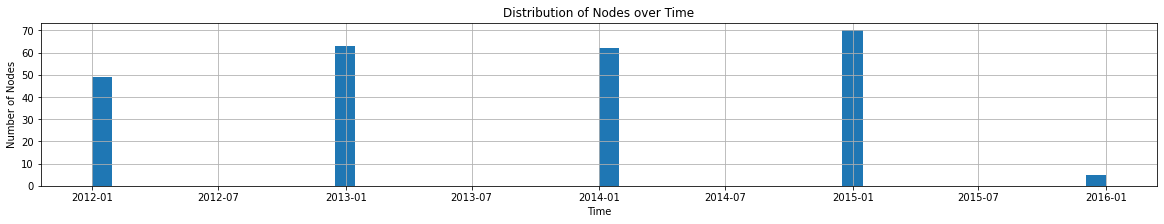

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.044374,icdm,0.119497,Linli Xu,0.012292,icdm,0.0,Mohammad Ali Bagheri
1,0.001030,Jing Gao,0.091951,icdm,0.000268,Jing Gao,0.0,Forensic Style Analysis with Survival Trajecto...
2,0.000936,J&eacute,0.053762,Word Embedding Revisited: A New Representation...,0.000255,J&eacute,0.0,Large-Scale Unusual Time Series Detection.
3,0.000749,Hao Wang,0.030775,Feature Selection with Integrated Relevance an...,0.000214,Hao Wang,0.0,Top-K interesting subgraph discovery in inform...
4,0.000655,Jure Leskovec,0.030775,Robust Dynamic Trajectory Regression on Road N...,0.000187,Siyuan Liu,0.0,Anytime OPTICS: An Efficient Approach for Hier...
5,0.000655,Siyuan Liu,0.030739,Learning Low-Rank Label Correlations for Multi...,0.000179,Jure Leskovec,0.0,Max-Intensity: Detecting Competitive Advertise...
6,0.000562,Xindong Wu,0.026928,Yitan Li,0.000161,Xuan Hong Dang,0.0,Mining Temporal Profiles of Mobile Application...
7,0.000562,Hsun-Ping Hsieh,0.005097,J&eacute,0.000158,Ira Assent,0.0,Explaining Outliers by Subspace Separability.
8,0.000562,Ira Assent,0.002912,Siyuan Liu,0.000156,Xiaoxiao Shi,0.0,Identifying Search Keywords for Finding Releva...
9,0.000562,Nicola Barbieri,0.002332,Characterizing Multi-Agent Team Behavior from ...,0.000156,Xindong Wu,0.0,Building a Large Scale Dataset for Image Emoti...


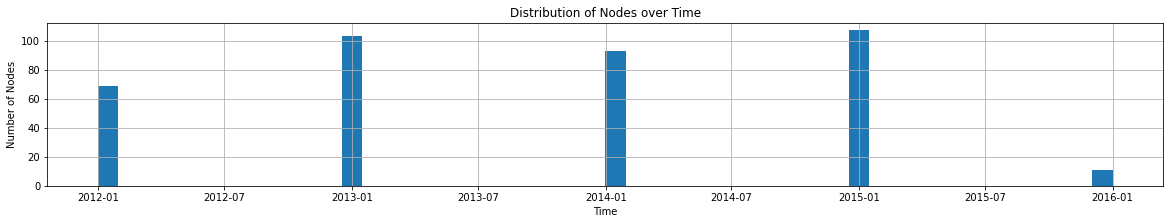

In [51]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [52]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.7211287840035825
Number of communities: 736


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

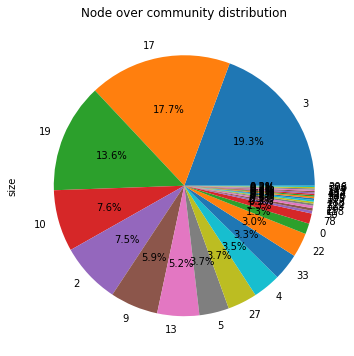

In [53]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.008800,vldb,0.014569,vldb,0.002562,vldb,0.0,Abdul Quamar
1,0.000562,Martin Faust,0.005498,On k-Path Covers and their applications.,0.000155,Martin Faust,0.0,Diversified top-k clique search.
2,0.000468,David Schwalb,0.003026,Equality-Friendly Well-Founded Semantics and A...,0.000144,Muhammad Aamir Cheema,0.0,Assigning global relevance scores to DBpedia f...
3,0.000468,Muhammad Aamir Cheema,0.002114,Jeremy Hyrkas,0.000129,David Schwalb,0.0,Leveraging in-memory technology for interactiv...
4,0.000281,Conformity-aware influence maximization in onl...,0.001951,The matrix mechanism: optimizing linear counti...,0.000117,Quantifying eventual consistency with PBS.,0.0,Sorting networks on FPGAs.
5,0.000281,Similarity queries: their conceptual evaluatio...,0.001926,ClouDiA: a deployment advisor for public clouds.,0.000106,Assigning global relevance scores to DBpedia f...,0.0,Measuring structural similarity of semistructu...
6,0.000281,Efficient k-closest pair queries in general me...,0.001104,Georg Gottlob,0.000106,Efficient order dependency detection.,0.0,Top-k Similarity Join over Multi-valued Objects.
7,0.000281,Diversified top-k clique search.,0.001021,Instance-level worst-case query bounds on R-tr...,0.000106,Windowed pq-grams for approximate joins of dat...,0.0,Compiled Plans for In-Memory Path-Counting Que...
8,0.000281,Instance-level worst-case query bounds on R-tr...,0.001010,OXPath: A language for scalable data extractio...,0.000106,Measuring structural similarity of semistructu...,0.0,Efficiently Monitoring Top-k Pairs over Slidin...
9,0.000281,Efficient order dependency detection.,0.001010,Sorting networks on FPGAs.,0.000106,Fast rule mining in ontological knowledge base...,0.0,SLICE: Reviving regions-based pruning for reve...


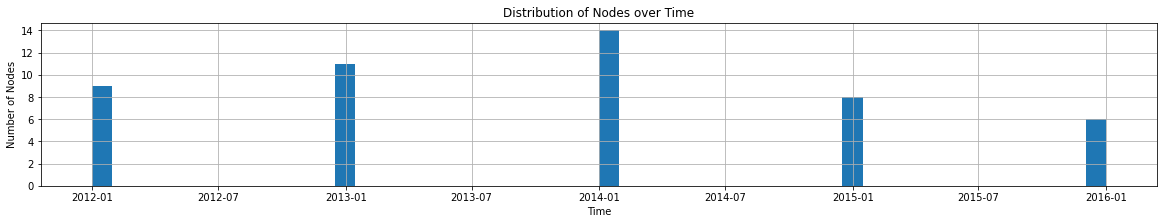

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000281,Entropy-based automated wrapper generation for...,0.000187,Entropy-based automated wrapper generation for...,0.000118,Entropy-based automated wrapper generation for...,0.0,Entropy-based automated wrapper generation for...
1,0.000094,Karen Stepanyan,0.000000,Karen Stepanyan,0.000048,Karen Stepanyan,NaN,Karen Stepanyan
2,0.000094,George Gkotsis,0.000000,George Gkotsis,0.000048,George Gkotsis,NaN,George Gkotsis


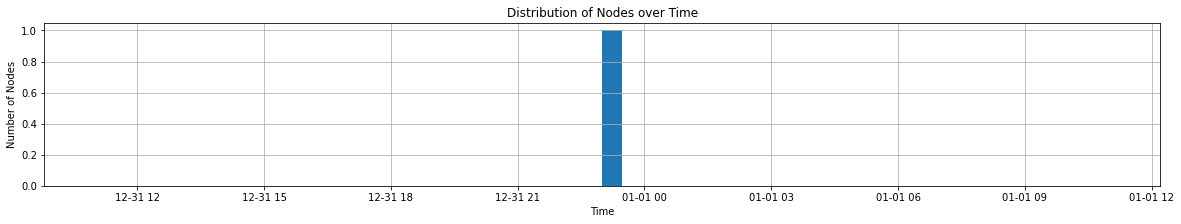

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.044374,icdm,0.091951,icdm,0.012292,icdm,0.0,Uwe Aickelin
1,0.001030,Jing Gao,0.030775,Feature Selection with Integrated Relevance an...,0.000268,Jing Gao,0.0,A Framework to Recommend Interventions for 30-...
2,0.000843,Fuzhen Zhuang,0.030739,Learning Low-Rank Label Correlations for Multi...,0.000238,Fuzhen Zhuang,0.0,Fast Random Walk Graph Kernel.
3,0.000749,Hao Wang,0.003889,Graph stream classification using labeled and ...,0.000214,Hao Wang,0.0,Conditional Log-linear Models for Mobile Appli...
4,0.000749,Xingquan Zhu,0.003109,Active Learning from Oracle with Knowledge Bli...,0.000192,Xingquan Zhu,0.0,A Weighted Support Vector Data Description Bas...
5,0.000655,Hanghang Tong,0.002529,Xingquan Zhu,0.000174,Hanghang Tong,0.0,"Senders, Receivers and Authors in Document Cla..."
6,0.000562,Nicola Barbieri,0.000834,Discriminative Multi-Task Feature Selection.,0.000153,Nicola Barbieri,0.0,Directional Higher Order Information for Spati...
7,0.000468,Junjie Wu,0.000750,Relational Stacked Denoising Autoencoder for T...,0.000150,Rui Liu,0.0,Unsupervised Clustering Strategy Based on Labe...
8,0.000468,Shusaku Tsumoto,0.000646,Yahong Han,0.000142,Junjie Wu,0.0,Rapidly Labeling and Tracking Dynamically Evol...
9,0.000468,U. Kang,0.000519,Jichang Zhao,0.000137,Yanjie Fu,0.0,Application-Managed Database Replication on Vi...


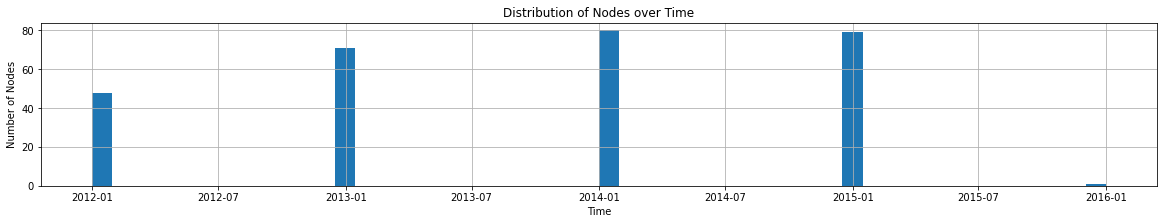

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.097454,aaai,0.853482,aaai,0.025851,aaai,0.0,Hailong Sun
1,0.001217,Chris H. Q. Ding,0.008331,Chao Zhang,0.000309,Deguang Kong,0.0,PROTECT: An Application of Computational Game ...
2,0.001217,Deguang Kong,0.008238,Wei Chen,0.000300,Chris H. Q. Ding,0.0,Towards Tractable and Practical ABox Abduction...
3,0.001123,Yang Yang,0.007328,Jing He,0.000293,Yang Yang,0.0,One Size Does Not Fit All: A Game-Theoretic Ap...
4,0.000843,Wei Chen,0.006371,Deguang Kong,0.000236,Wei Chen,0.0,The Complexity Landscape of Decompositional Pa...
5,0.000843,Edith Elkind,0.006063,Chris H. Q. Ding,0.000218,Edith Elkind,0.0,Fine-Grained Photovoltaic Output Prediction Us...
6,0.000749,Chao Zhang,0.005454,Yang Yang,0.000209,Diego Calvanese,0.0,Feature Selection at the Discrete Limit.
7,0.000749,Diego Calvanese,0.005445,Write-righter: An Academic Writing Assistant S...,0.000205,Chao Zhang,0.0,STREETS: Game-Theoretic Traffic Patrolling wit...
8,0.000749,Piotr Faliszewski,0.005398,Exploring Social Context for Topic Identificat...,0.000199,Jie Tang,0.0,Dropout Training for Support Vector Machines.
9,0.000749,Arthur Choi,0.005398,Modeling Status Theory in Trust Prediction.,0.000198,Arthur Choi,0.0,Incentivizing High-Quality Content from Hetero...


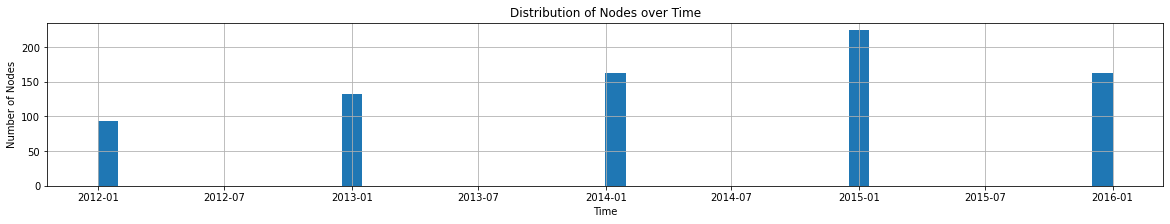

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.017974,sdm,0.018024,sdm,0.004806,sdm,0.0,James Bailey
1,0.000843,Charu C. Aggarwal,0.001678,Wei Fan,0.000216,Charu C. Aggarwal,0.0,"Retweeting: An Act of Viral Users, Susceptible..."
2,0.000655,Ruilin Liu,0.001045,Tutorial: Data Stream Mining and Its Applicati...,0.000188,Ruilin Liu,0.0,Less is More: Building Selective Anomaly Ensem...
3,0.000562,Karthik Subbian,0.001004,A Framework for Outlier Description Using Cons...,0.000162,Leman Akoglu,0.0,Batch Mode Active Learning with Hierarchical-S...
4,0.000562,Xiaoxiao Shi,0.000976,James Bailey,0.000157,Yu Cheng,0.0,Recurrent Chinese Restaurant Process with a Du...
5,0.000562,Philip S. Yu,0.000909,Transfer Learning in Collaborative Filtering w...,0.000156,Xiaoxiao Shi,0.0,Reliability Prediction of Webpages in the Medi...
6,0.000562,Wei Fan,0.000800,Obtaining Well Calibrated Probabilities Using ...,0.000156,Wei Fan,0.0,GBPR: Group Preference Based Bayesian Personal...
7,0.000562,Leman Akoglu,0.000762,Zheng Chen,0.000150,Philip S. Yu,0.0,Extracting Researcher Metadata with Labeled Fe...
8,0.000562,Yu Cheng,0.000659,Ian Davidson,0.000148,Karthik Subbian,0.0,Social Role Identification via Dual Uncertaint...
9,0.000468,William W. Cohen,0.000646,Mobile App Security Risk Assessment: A Crowdso...,0.000138,Ian Davidson,0.0,A Statistical Learning Theory Framework for Su...


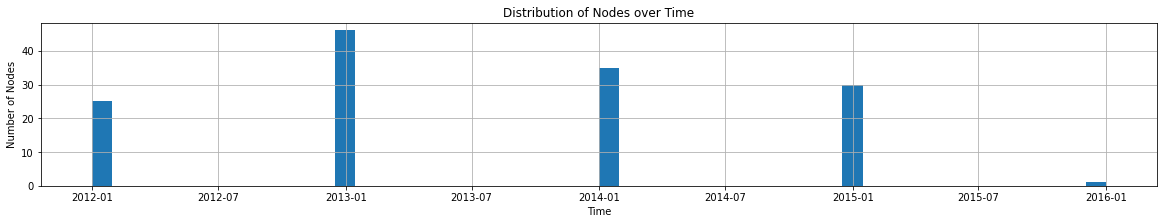

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.022468,pkdd,0.029932,pkdd,0.006225,pkdd,0.0,Michael Kamp
1,0.001217,Andr&eacute,0.007223,Andr&eacute,0.000328,Andr&eacute,0.0,Scalable Nonnegative Matrix Factorization with...
2,0.000936,Huzefa Rangwala,0.002194,Incremental Stochastic Factorization for Onlin...,0.000245,Huzefa Rangwala,0.0,Cautious Ordinal Classification by Binary Deco...
3,0.000468,Christos Faloutsos,0.002194,Tree-Based On-Line Reinforcement Learning.,0.000133,Christos Faloutsos,0.0,Max-Intensity: Detecting Competitive Advertise...
4,0.000374,da Motta Salles Barreto,0.001791,Unsupervised Feature Analysis with Class Margi...,0.000116,Scalable Nonnegative Matrix Factorization with...,0.0,Score As You Lift (SAYL): A Statistical Relati...
5,0.000374,Sebastian Tschiatschek,0.001746,On-line Reinforcement Learning Using Increment...,0.000115,Maximilian Nickel,0.0,Multiview Triplet Embedding: Learning Attribut...
6,0.000374,Christoph Sawade,0.001710,OMNI-Prop: Seamless Node Classification on Arb...,0.000111,Thomas Seidl 0001,0.0,Mobility Mining for Journey Planning in Rome.
7,0.000374,Maximilian Nickel,0.001208,Sebastian Tschiatschek,0.000111,Christoph Sawade,0.0,Density-Based Subspace Clustering in Heterogen...
8,0.000374,Thomas Seidl 0001,0.001166,Christos Faloutsos,0.000111,Sebastian Tschiatschek,0.0,CC-MR - Finding Connected Components in Huge G...
9,0.000281,Automatically Mapped Transfer between Reinforc...,0.001100,Maximilian Nickel,0.000105,Trajectory Data Pattern Mining.,0.0,Learning a Manifold as an Atlas.


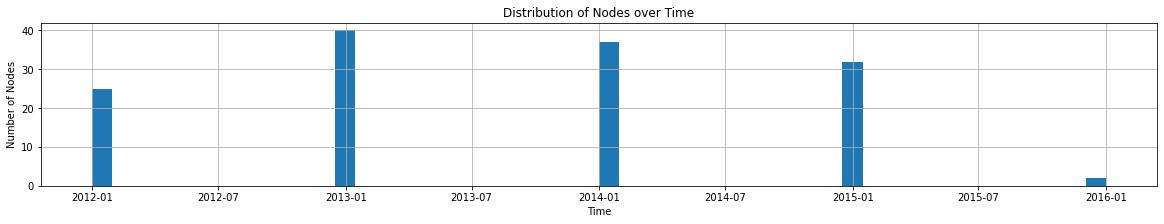

In [54]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')